In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data

subroutine.py

In [3]:
import csv
def return_HM_npy(csvfile_path):
    H=[]
    M=[]
    with open(csvfile_path, 'r') as f:
        reader=csv.reader(f)
        header=next(reader) #skip header
        for row in reader:
            H.append(float(row[0]))
            M.append(float(row[1]))
    return np.array(H), np.array(M)

def accept_middle(H, M, noise_std=0.1, f=None):
    noise=abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else: return False

def generate_data(noise_std=0.1, datasize=10000, Hrange=[0.0, 6.0], Mrange=[0.0, 2.0], f=None):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1])
        M=np.random.uniform(Mrange[0], Mrange[1])
        if accept_middle(H, M, noise_std, f) and len(Hp)<datasize:
            Hp.append([H])
            Mp.append([M])
            Fp.append([0])
        elif len(Hn)<datasize:
            Hn.append([H])
            Mn.append([M])
            Fn.append([1])
        if len(Hp)>=datasize and len(Hn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(H, M, Positive_HM, Negative_HM, f):
    plt.xlabel('H')
    plt.ylabel('M')
    plt.plot(Negative_HM[0], Negative_HM[1], 'y.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'b.', label='positive')
    hs=np.linspace(np.min(H), np.max(H), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(H, M, 'ro', label='data')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

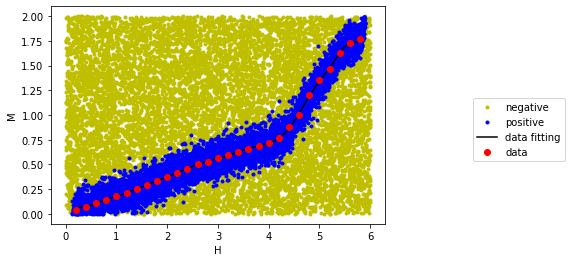

In [4]:
H,M=return_HM_npy('MHfile.csv')
f=np.poly1d(np.polyfit(H,M,deg=15))
Positive_HM, Negative_HM = generate_data(datasize=10000, f=f)
plot_all(H, M, Positive_HM, Negative_HM, f)

## Reformat training data
Make training data by class called 'Dataset'.

In [5]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [6]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [7]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, pi, eta=None):
    ''' returning Pi'''
    F=pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        self.lamb=nn.Linear(1, 1, bias=False)
        self.m2=nn.Linear(1, 1, bias=False)
        self.alpha=nn.Linear(1, 1, bias=False)
        self.beta=nn.Linear(1, 1, bias=False)
        
        #fixed parameters
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
        
    def show_lamb(self):
        return self.lamb(self.one)
    def show_m2(self):
        return self.m2(self.one)
    def show_alpha(self):
        return self.alpha(self.one)
    def show_beta(self):
        return self.beta(self.one)
    
    def penalty(self, coef_list=None):
        penalty=0
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layer))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        pH=self.Hs[0](self.one)
        for i in range(1, self.N_layer):
            H = self.Hs[i]
            if H==self.Hs[9]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = penalty + c_reg2*(1/self.eta_fin - H(self.one))**2
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
    
    def forward(self, H=None, M=None):
        #initial layer
        D=torch.sqrt(torch.abs(1+4*self.m2(self.one)/(self.Hs[0](self.one)**2)))
        phi=self.alpha(self.one)*H + self.beta(self.one)*M
        pi=(d/2)*(D-1)*self.alpha(self.one)*H + (d/2)*(-D-1)*self.beta(self.one)*M
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2(self.one), 
                              lamb=self.lamb(self.one), del_eta=self.del_eta)
        ff=f(phi, pi, eta=eta(self.N_layer, self.eta_ini, self.eta_fin, self.N_layer))
        final = t(ff, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, pi=None, answer=None, reg_coef_list=None):
        model_output=self.forward(H=phi, M=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    for i in range (len(Model.Hs)):
        w=np.random.normal(2, 1)
        Model.Hs[i].weight.data.fill_(w)
    m2=np.random.normal(2, 1)
    lamb=np.random.normal(1, 1)
    alpha=np.random.uniform(-0.5, 0.5)
    beta=np.random.uniform(-0.5, 0.5)
    Model.m2.weight.data.fill_(m2)
    Model.lamb.weight.data.fill_(lamb)
    Model.alpha.weight.data.fill_(alpha)
    Model.beta.weight.data.fill_(beta)    

In [8]:
d=4
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
c_reg1=0.003
c_reg2=0.0001

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta, d=d)
init_weights(Test, d)
optimizer = torch.optim.Adam(Test.parameters())
Test.train()
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(c_reg1*eta(i, eta_ini, eta_fin, N_layer)**4)
    
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layer)]
print("H: ", np.array(a))
print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))

H:  [1.7405772 1.1364244 1.6939619 2.4998198 1.8047456 0.8172143 2.9947045
 1.672783  1.9007026 0.6755298]
m2: 2.260979413986206, lambda: 1.1636524200439453, alpha: 0.13249734044075012, beta: 0.06015230342745781


# 3. Train NN

In [9]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(H=phis, M=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('M', fontsize=12)
    al.set_ylabel('H', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layer,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

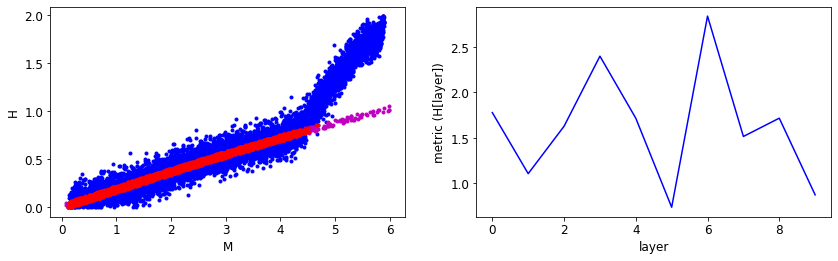

training epoch: 0,   loss: 0.18433378636837006
m2: 2.205960750579834, lambda: 1.1825087070465088, alpha: 0.09329280257225037, beta: 0.08188188821077347
[1.77878082 1.10781109 1.62884998 2.39908195 1.71694851 0.73848301
 2.83926964 1.51651299 1.71742332 0.87465841]


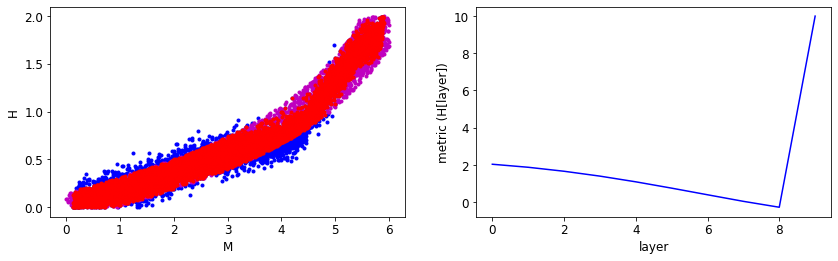

training epoch: 100,   loss: 0.010320900939404964
m2: 1.012978196144104, lambda: -2.266974449157715, alpha: 0.09546393901109695, beta: 0.04511253163218498
[ 2.03433681  1.87164497  1.65727592  1.39545894  1.0890168   0.74857628
  0.39279976  0.03918707 -0.27802253  9.99999428]


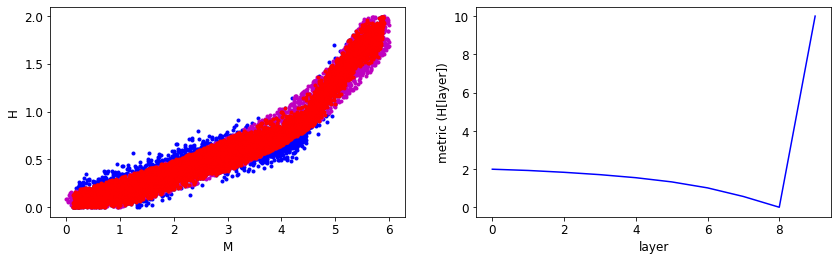

training epoch: 200,   loss: 0.010177671909332275
m2: 0.6707957983016968, lambda: -2.0502514839172363, alpha: 0.09130009263753891, beta: 0.039308153092861176
[1.99627841e+00 1.93104553e+00 1.83486784e+00 1.71218610e+00
 1.55289924e+00 1.33412302e+00 1.02078414e+00 5.70481598e-01
 8.30951519e-03 1.00000000e+01]


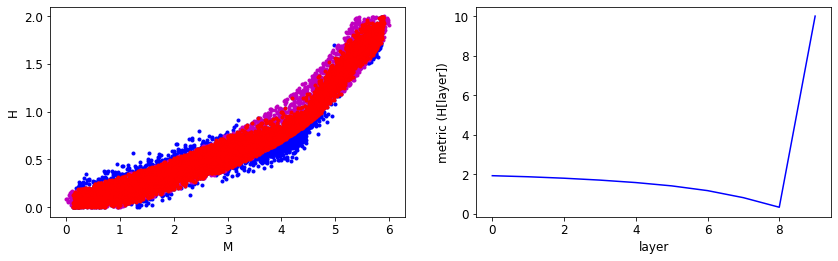

training epoch: 300,   loss: 0.009928230196237564
m2: 0.5430284738540649, lambda: -1.8701142072677612, alpha: 0.09418988972902298, beta: 0.03825560212135315
[ 1.91566098  1.86194956  1.78822136  1.69248605  1.56804013  1.40035558
  1.16004407  0.80254579  0.31777793 10.        ]


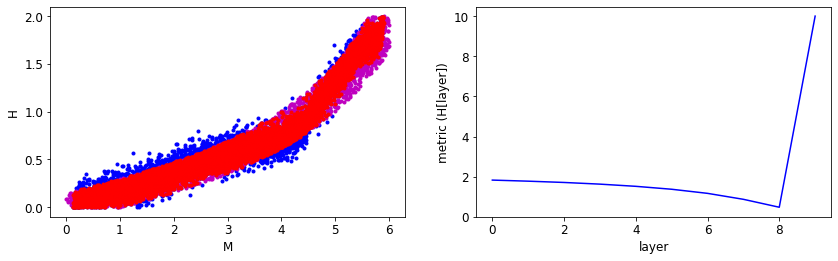

training epoch: 400,   loss: 0.009880313649773598
m2: 0.4685436487197876, lambda: -1.6957038640975952, alpha: 0.09466483443975449, beta: 0.04219581186771393
[ 1.82898307  1.77517009  1.71102893  1.62754881  1.51861858  1.37266207
  1.16813326  0.87121439  0.47612894 10.        ]


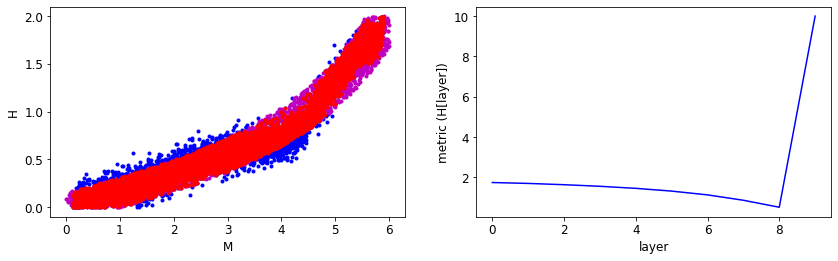

training epoch: 500,   loss: 0.009577852673828602
m2: 0.41532474756240845, lambda: -1.520674228668213, alpha: 0.09660068899393082, beta: 0.04208485037088394
[ 1.74297655  1.69849646  1.63464534  1.55627644  1.45402849  1.31733477
  1.12934828  0.86281949  0.51645488 10.        ]


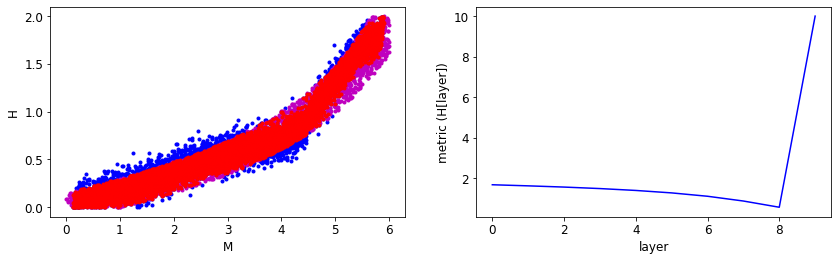

training epoch: 600,   loss: 0.00977630726993084
m2: 0.35941967368125916, lambda: -1.3570371866226196, alpha: 0.09989913552999496, beta: 0.04521294683218002
[ 1.67511559  1.62113643  1.56055248  1.48677349  1.39414406  1.27296352
  1.10701275  0.87179846  0.56483132 10.        ]


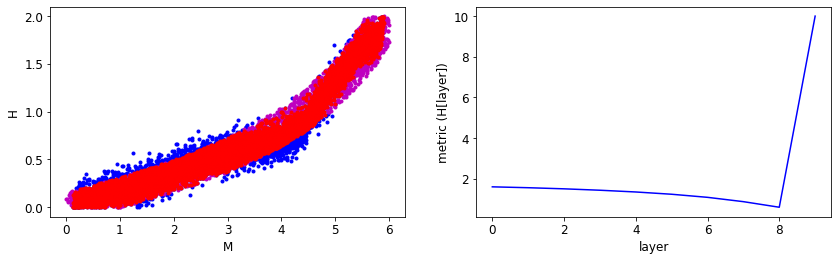

training epoch: 700,   loss: 0.009531253948807716
m2: 0.319710910320282, lambda: -1.1955533027648926, alpha: 0.1044340580701828, beta: 0.045279864221811295
[ 1.60714507  1.56373489  1.50905991  1.44008398  1.35409796  1.24247813
  1.09077096  0.8781752   0.60371721 10.        ]


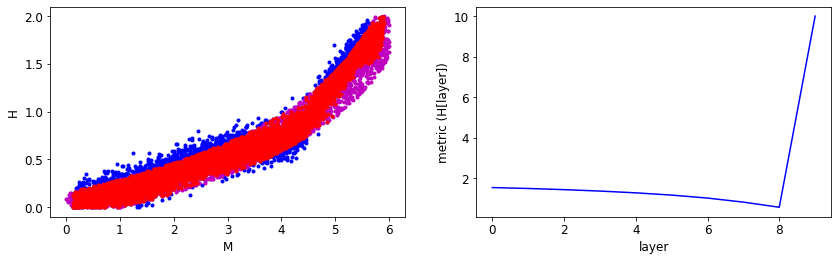

training epoch: 800,   loss: 0.010125478729605675
m2: 0.28520745038986206, lambda: -1.0549293756484985, alpha: 0.10786180943250656, beta: 0.050332486629486084
[ 1.54438174  1.49859953  1.44180465  1.37116659  1.28342724  1.17194569
  1.02529299  0.82544762  0.57317305 10.        ]


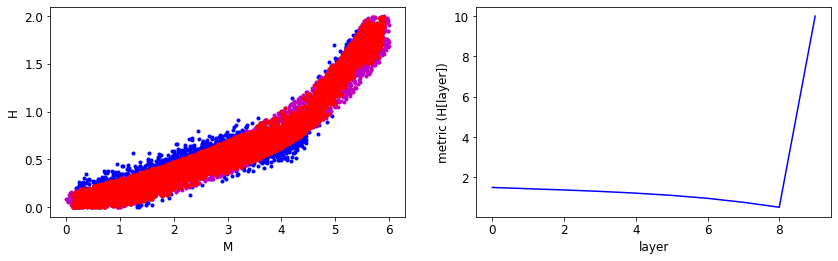

training epoch: 900,   loss: 0.010205583646893501
m2: 0.2518807053565979, lambda: -0.9245745539665222, alpha: 0.11585008352994919, beta: 0.05209987238049507
[ 1.48660553  1.42441607  1.36278617  1.29239321  1.204597    1.09287977
  0.94641846  0.74940592  0.50394928 10.        ]


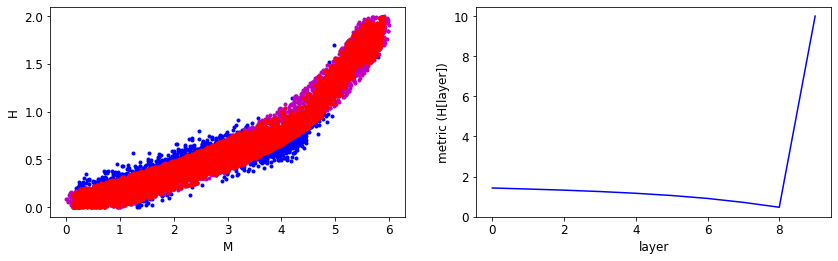

training epoch: 1000,   loss: 0.009738782420754433
m2: 0.2291455715894699, lambda: -0.8082101941108704, alpha: 0.12283062934875488, beta: 0.05375707522034645
[ 1.42874682  1.37629676  1.32018268  1.25131345  1.16431451  1.05321813
  0.90733135  0.71089995  0.46805835 10.        ]


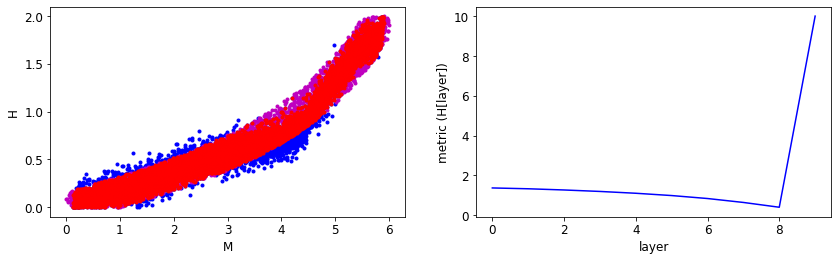

training epoch: 1100,   loss: 0.009764709509909153
m2: 0.21328961849212646, lambda: -0.6993430852890015, alpha: 0.12746715545654297, beta: 0.0542152114212513
[ 1.37262821  1.33106768  1.27085555  1.19707417  1.105829    0.99050277
  0.84147328  0.64426064  0.40367463 10.        ]


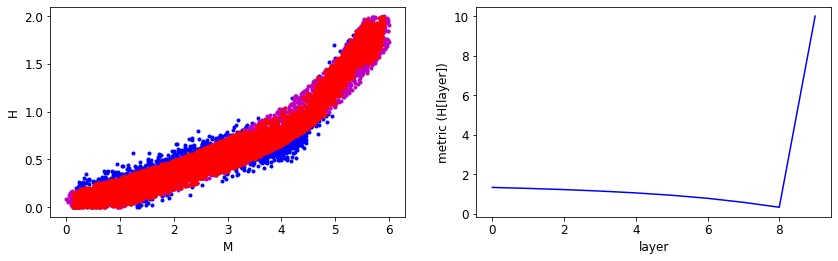

training epoch: 1200,   loss: 0.009605446830391884
m2: 0.18939948081970215, lambda: -0.6057005524635315, alpha: 0.1345641165971756, beta: 0.05839647725224495
[ 1.32798028  1.27935934  1.21938145  1.14447606  1.05067277  0.93200666
  0.77790177  0.57341355  0.32517841 10.        ]


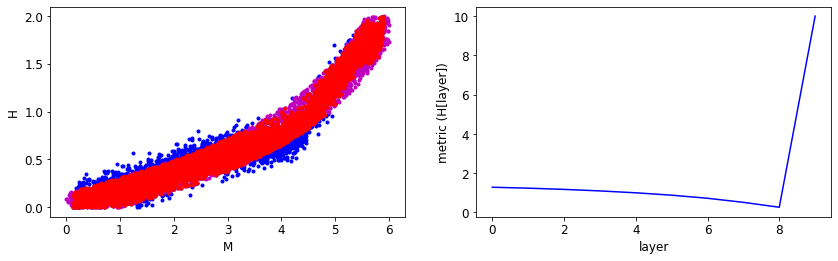

training epoch: 1300,   loss: 0.00972738116979599
m2: 0.17380499839782715, lambda: -0.5268504619598389, alpha: 0.14266641438007355, beta: 0.062268342822790146
[ 1.28258932  1.23668802  1.17439008  1.09633756  0.99969333  0.87845445
  0.72125     0.51398546  0.26440394 10.        ]


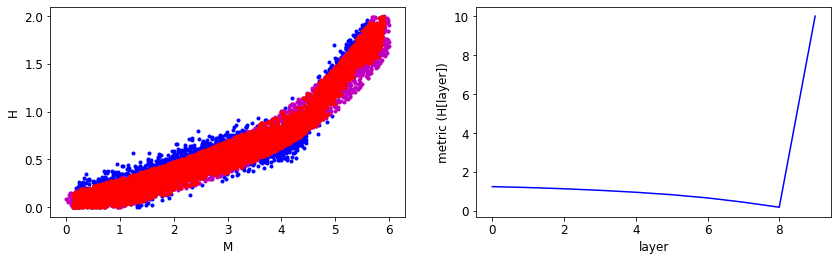

training epoch: 1400,   loss: 0.009515928104519844
m2: 0.1573721468448639, lambda: -0.4640233516693115, alpha: 0.14811180531978607, beta: 0.06636923551559448
[ 1.23981428  1.19332612  1.12999856  1.04987717  0.95073622  0.82461435
  0.65960324  0.44130257  0.18066934 10.        ]


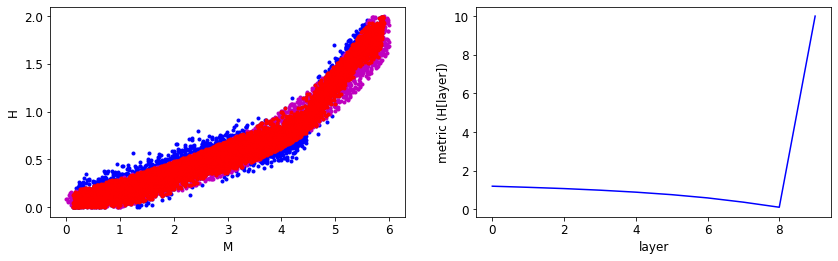

training epoch: 1500,   loss: 0.009674519300460815
m2: 0.14274244010448456, lambda: -0.4132334887981415, alpha: 0.15433374047279358, beta: 0.06805352121591568
[ 1.20247138  1.1448307   1.07927704  0.99680996  0.89441752  0.7648629
  0.59705883  0.37674132  0.11403307 10.        ]


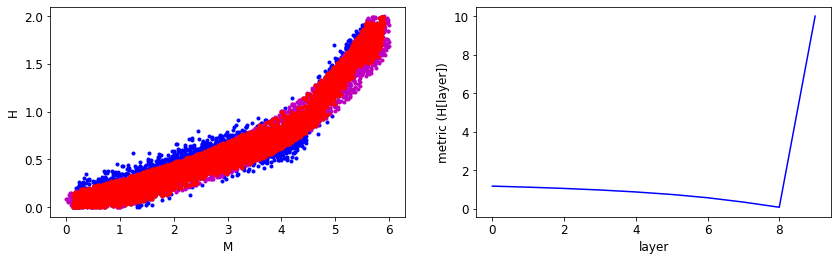

training epoch: 1600,   loss: 0.009676379151642323
m2: 0.12967438995838165, lambda: -0.3768477141857147, alpha: 0.1622331440448761, beta: 0.07179366052150726
[ 1.16860747  1.11339426  1.04874229  0.96742612  0.865596    0.73551077
  0.56480694  0.33909044  0.07105106 10.        ]


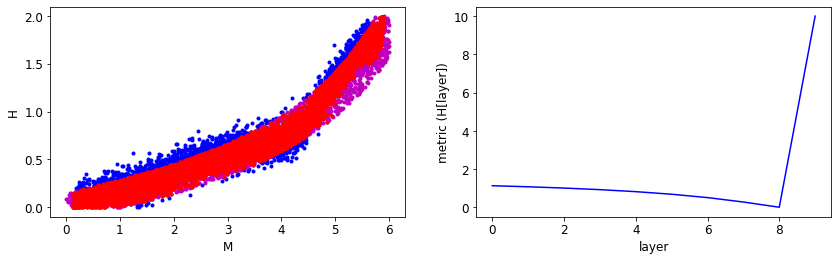

training epoch: 1700,   loss: 0.009658548049628735
m2: 0.12171675264835358, lambda: -0.3456313908100128, alpha: 0.16653691232204437, beta: 0.07667496800422668
[ 1.1373775   1.08244812  1.01570749  0.9322685   0.82729995  0.69275999
  0.51689625  0.28611213  0.01296722 10.        ]


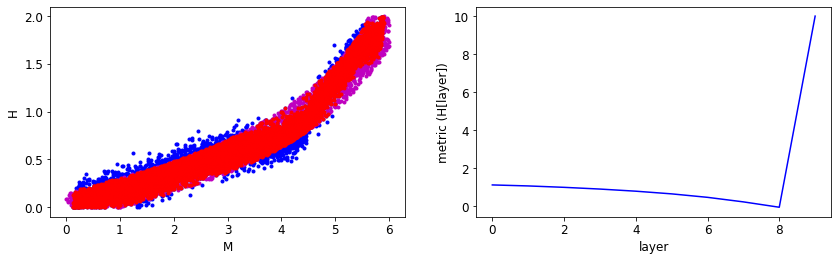

training epoch: 1800,   loss: 0.009379170835018158
m2: 0.1204562783241272, lambda: -0.3183353841304779, alpha: 0.17209842801094055, beta: 0.07698265463113785
[ 1.10708976  1.0542376   0.98046023  0.88945782  0.77730495  0.63613355
  0.45337886  0.21417795 -0.06834956 10.        ]


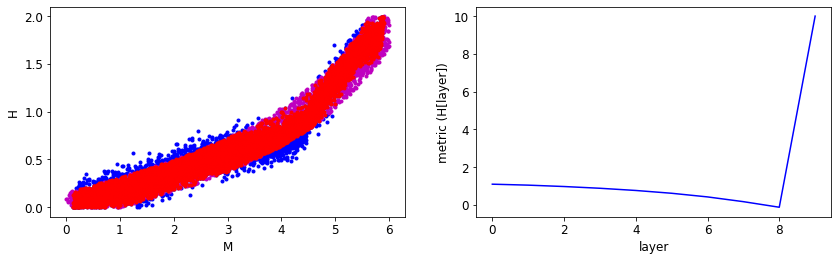

training epoch: 1900,   loss: 0.00962530355900526
m2: 0.11656421422958374, lambda: -0.29232457280158997, alpha: 0.17608721554279327, beta: 0.0771547183394432
[ 1.08408856  1.03335321  0.96009278  0.86752611  0.75084382  0.60208845
  0.40893996  0.15690781 -0.13908924 10.        ]


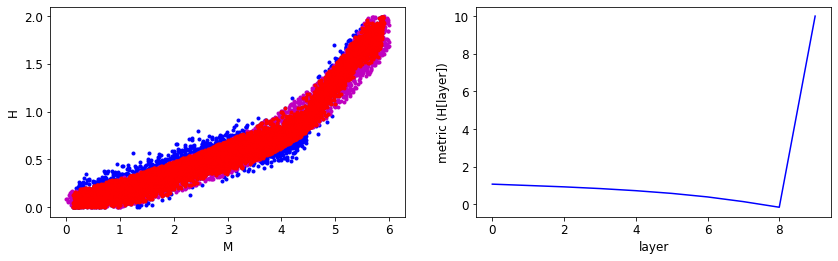

training epoch: 2000,   loss: 0.009792828001081944
m2: 0.1039670929312706, lambda: -0.2819594144821167, alpha: 0.181636780500412, beta: 0.07943311333656311
[ 1.06894469  0.99784034  0.92501593  0.83437175  0.72161758  0.57799244
  0.38973784  0.1399928  -0.15872253 10.        ]


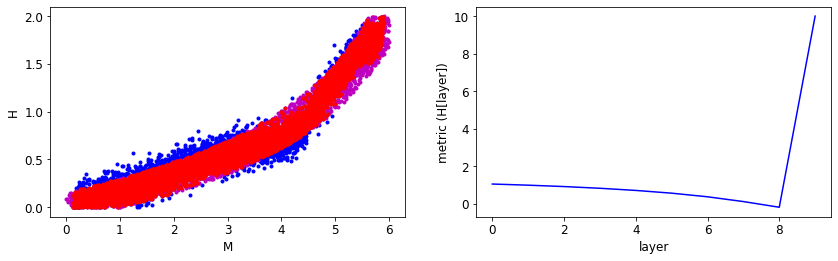

training epoch: 2100,   loss: 0.009691757149994373
m2: 0.10126952081918716, lambda: -0.26846712827682495, alpha: 0.18608617782592773, beta: 0.08238405734300613
[ 1.05168116  0.99048287  0.91726106  0.82593274  0.71116644  0.56444097
  0.37192467  0.11723831 -0.18509437 10.        ]


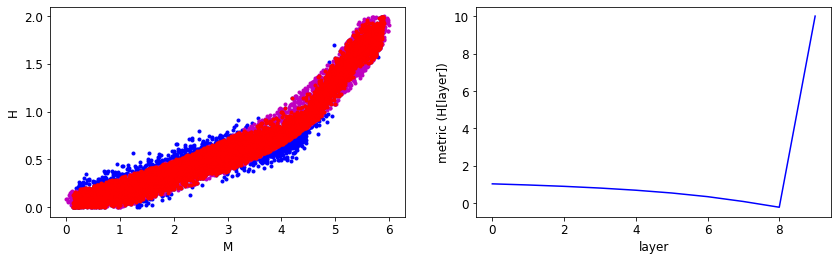

training epoch: 2200,   loss: 0.009476806968450546
m2: 0.09951617568731308, lambda: -0.2594459354877472, alpha: 0.19054292142391205, beta: 0.08163142949342728
[ 1.03739405  0.97687453  0.90418047  0.81262237  0.69701523  0.54853094
  0.35311091  0.09423468 -0.21299314 10.        ]


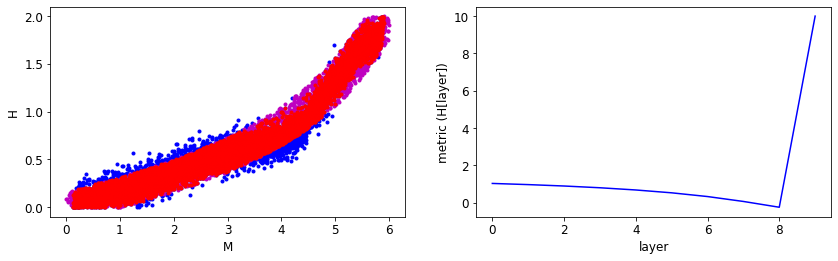

training epoch: 2300,   loss: 0.009460565634071827
m2: 0.09809854626655579, lambda: -0.2509220540523529, alpha: 0.19077518582344055, beta: 0.08191695064306259
[ 1.02490211  0.96226549  0.88688189  0.7929526   0.67417991  0.52146041
  0.32140836  0.05835317 -0.25216672 10.        ]


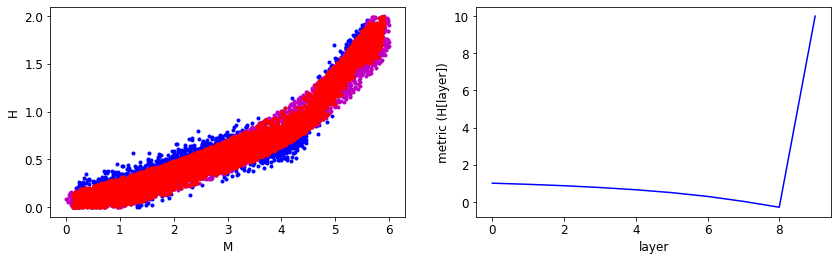

training epoch: 2400,   loss: 0.009372645989060402
m2: 0.09780993312597275, lambda: -0.2430562973022461, alpha: 0.18966637551784515, beta: 0.08441586792469025
[ 1.01412404  0.95285094  0.87765211  0.78170747  0.6609211   0.50571895
  0.302488    0.03552056 -0.2798506  10.        ]


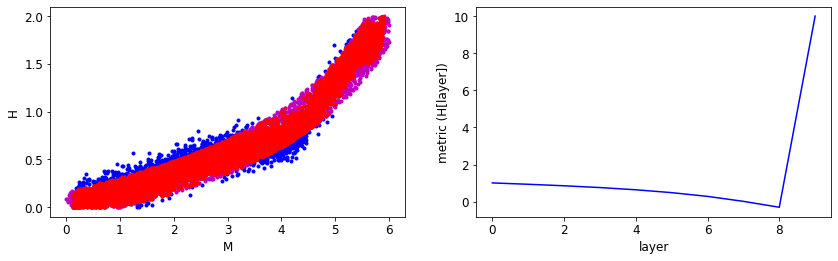

training epoch: 2500,   loss: 0.01005056407302618
m2: 0.09243495762348175, lambda: -0.24312330782413483, alpha: 0.19235998392105103, beta: 0.08401457220315933
[ 1.00838935  0.93544829  0.85440451  0.75851357  0.63859022  0.48473179
  0.28253642  0.01510903 -0.30261061 10.        ]


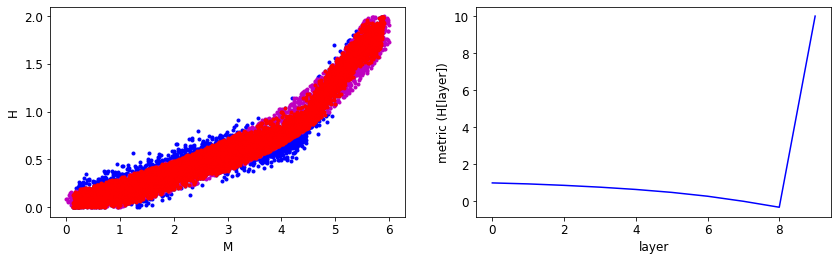

training epoch: 2600,   loss: 0.009579016827046871
m2: 0.09733542799949646, lambda: -0.23802660405635834, alpha: 0.19395893812179565, beta: 0.08685445040464401
[ 9.97015715e-01  9.43496644e-01  8.65369439e-01  7.67409503e-01
  6.44219398e-01  4.85954523e-01  2.78482974e-01  5.65196015e-03
 -3.16234142e-01  1.00000000e+01]


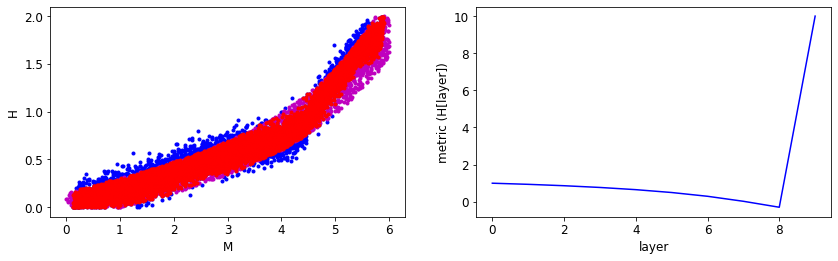

training epoch: 2700,   loss: 0.00961522851139307
m2: 0.09053434431552887, lambda: -0.2306138128042221, alpha: 0.1920592337846756, beta: 0.08628863841295242
[ 0.99380815  0.93351257  0.85830069  0.76489216  0.64612722  0.4921447
  0.28879347  0.01930984 -0.30168912 10.        ]


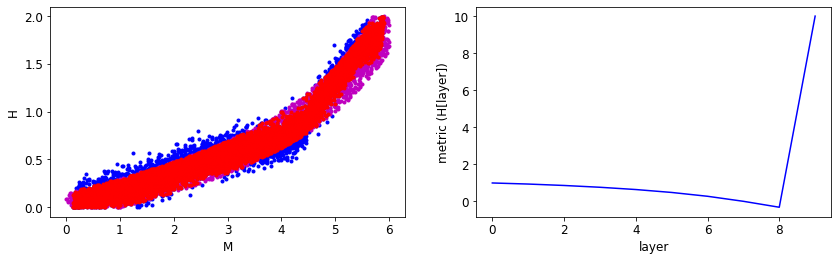

training epoch: 2800,   loss: 0.009547094814479351
m2: 0.09294858574867249, lambda: -0.23049409687519073, alpha: 0.1943916380405426, beta: 0.08870498836040497
[ 9.89763498e-01  9.31470931e-01  8.54777455e-01  7.57820427e-01
  6.35421634e-01  4.77852911e-01  2.71154433e-01 -3.12715943e-04
 -3.20872903e-01  1.00000000e+01]


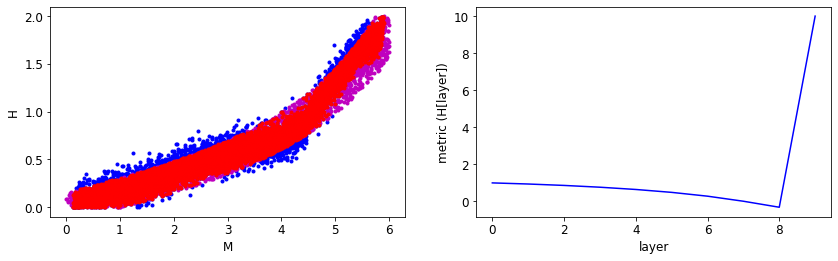

training epoch: 2900,   loss: 0.0093098608776927
m2: 0.09127048403024673, lambda: -0.22575977444648743, alpha: 0.19262287020683289, beta: 0.08706034719944
[ 9.86072540e-01  9.25811470e-01  8.49375248e-01  7.52844751e-01
  6.30775988e-01  4.74068463e-01  2.68015862e-01 -5.04460977e-03
 -3.29762161e-01  1.00000000e+01]


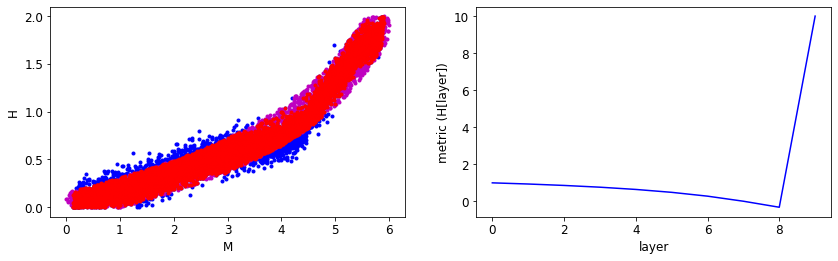

training epoch: 3000,   loss: 0.009575829841196537
m2: 0.09017426520586014, lambda: -0.22939977049827576, alpha: 0.19878023862838745, beta: 0.08676968514919281
[ 9.85509813e-01  9.22578335e-01  8.45391929e-01  7.50506699e-01
  6.29352212e-01  4.72450435e-01  2.65659690e-01 -8.19322467e-03
 -3.33513737e-01  1.00000000e+01]


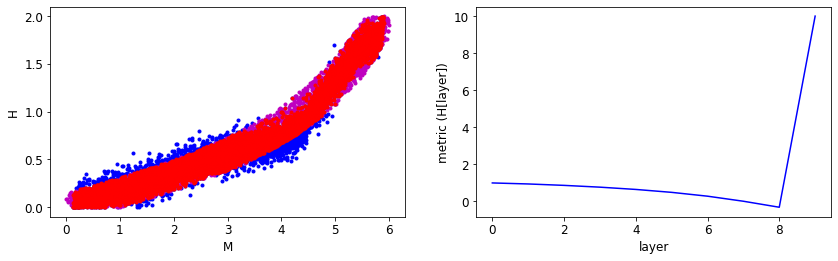

training epoch: 3100,   loss: 0.009482287801802158
m2: 0.09367947280406952, lambda: -0.2274021953344345, alpha: 0.1992160528898239, beta: 0.08826923370361328
[ 9.80169177e-01  9.24991846e-01  8.48698139e-01  7.51884699e-01
  6.29074574e-01  4.71078128e-01  2.63972461e-01 -9.32339393e-03
 -3.33810151e-01  1.00000000e+01]


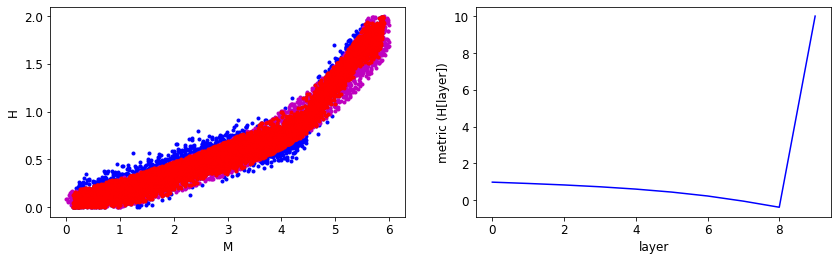

training epoch: 3200,   loss: 0.0098272655159235
m2: 0.08814775198698044, lambda: -0.22505022585391998, alpha: 0.19745512306690216, beta: 0.08836055546998978
[ 0.98599219  0.91450173  0.83419853  0.73475307  0.60881567  0.44693914
  0.23466924 -0.04500151 -0.37620497 10.        ]


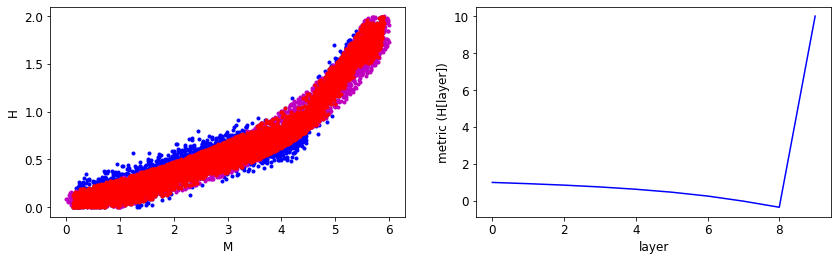

training epoch: 3300,   loss: 0.009553556330502033
m2: 0.08739243447780609, lambda: -0.22648978233337402, alpha: 0.19929620623588562, beta: 0.08896516263484955
[ 0.98319709  0.91540051  0.83657998  0.73784471  0.61345649  0.4540422
  0.24489222 -0.03218216 -0.36229482 10.        ]


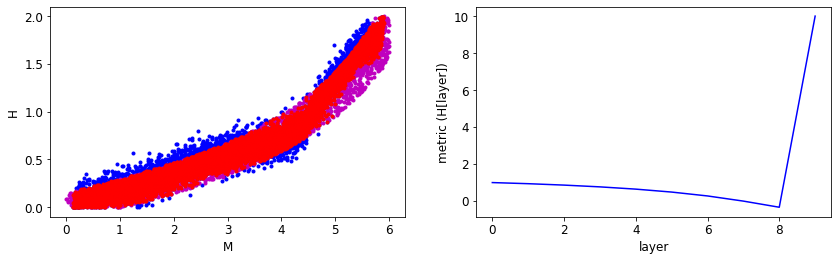

training epoch: 3400,   loss: 0.009713436476886272
m2: 0.0865546315908432, lambda: -0.21940156817436218, alpha: 0.19637100398540497, beta: 0.08977478742599487
[ 0.98112661  0.92058504  0.84406286  0.74832886  0.62580466  0.46667272
  0.25626656 -0.02304913 -0.35548401 10.        ]


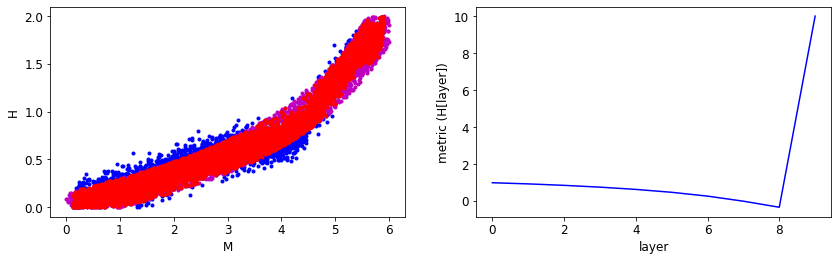

training epoch: 3500,   loss: 0.010096423327922821
m2: 0.08904792368412018, lambda: -0.2245066910982132, alpha: 0.20005585253238678, beta: 0.08972307294607162
[ 0.97766072  0.91539145  0.83609533  0.73921221  0.61713624  0.45998332
  0.25289723 -0.02178463 -0.34907401 10.        ]


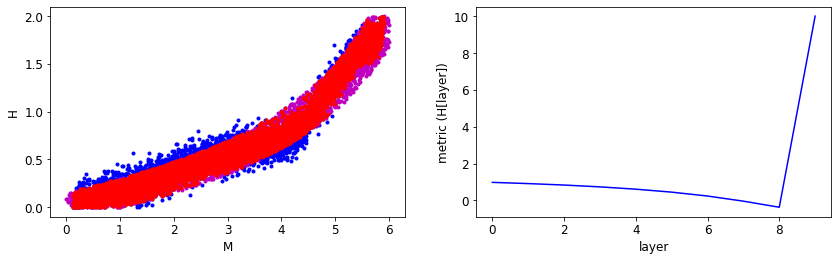

training epoch: 3600,   loss: 0.009813652373850346
m2: 0.0885293111205101, lambda: -0.22478993237018585, alpha: 0.19922181963920593, beta: 0.09025810658931732
[ 0.97852135  0.91225201  0.83334625  0.73396444  0.60858083  0.44789639
  0.23690516 -0.04178814 -0.37159529 10.        ]


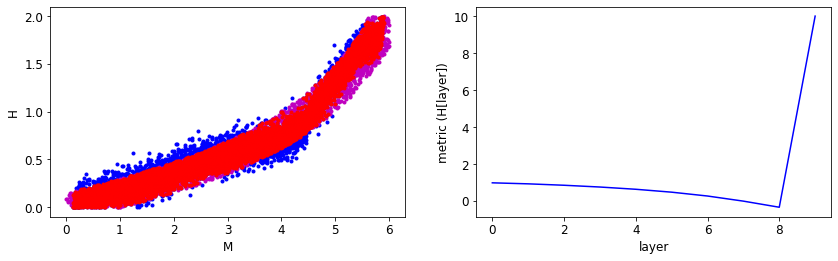

training epoch: 3700,   loss: 0.009610024280846119
m2: 0.08855953812599182, lambda: -0.22336070239543915, alpha: 0.1995767056941986, beta: 0.09105277806520462
[ 0.97606838  0.92103797  0.84450227  0.74862921  0.62711871  0.46979374
  0.26181006 -0.01500584 -0.3457149  10.        ]


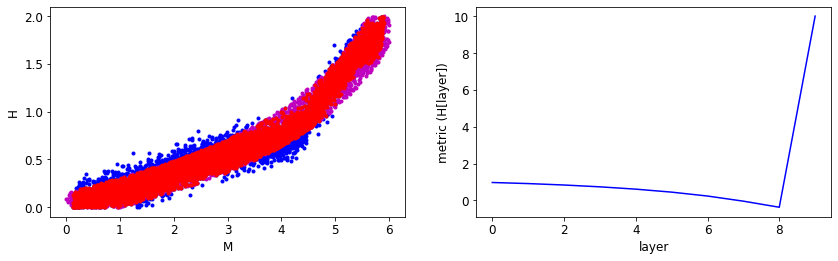

training epoch: 3800,   loss: 0.00937699619680643
m2: 0.09162796288728714, lambda: -0.22319751977920532, alpha: 0.19799359142780304, beta: 0.08947382867336273
[ 0.9732514   0.9141683   0.83677649  0.73767948  0.61186463  0.44991577
  0.23814389 -0.04016581 -0.36961487 10.        ]


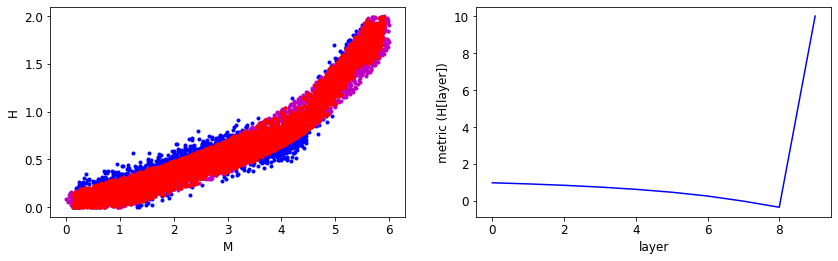

training epoch: 3900,   loss: 0.009539961814880371
m2: 0.08862494677305222, lambda: -0.22338330745697021, alpha: 0.19772149622440338, beta: 0.08839444071054459
[ 0.97177905  0.9114517   0.83577335  0.73983169  0.61840218  0.4615244
  0.25395635 -0.0226007  -0.35279298 10.        ]


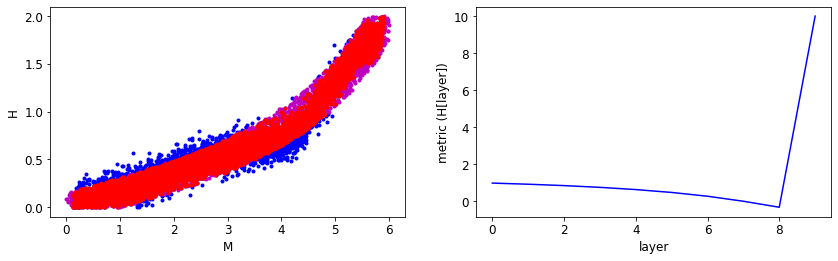

training epoch: 4000,   loss: 0.009582486934959888
m2: 0.08860999345779419, lambda: -0.2246999442577362, alpha: 0.1996535360813141, beta: 0.08846572786569595
[ 0.97157794  0.91002864  0.83558273  0.74082816  0.62050062  0.46545747
  0.26086339 -0.01088083 -0.33466578 10.        ]


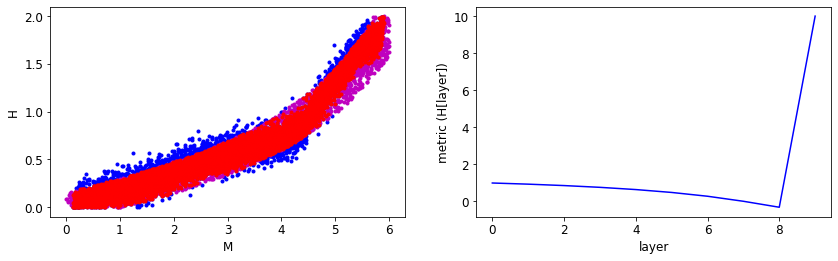

training epoch: 4100,   loss: 0.009479387663304806
m2: 0.08620264381170273, lambda: -0.22025322914123535, alpha: 0.19607557356357574, beta: 0.08845624327659607
[ 0.97367585  0.91135693  0.83504379  0.73963088  0.61893833  0.46296093
  0.25741175 -0.01445503 -0.33722404 10.        ]


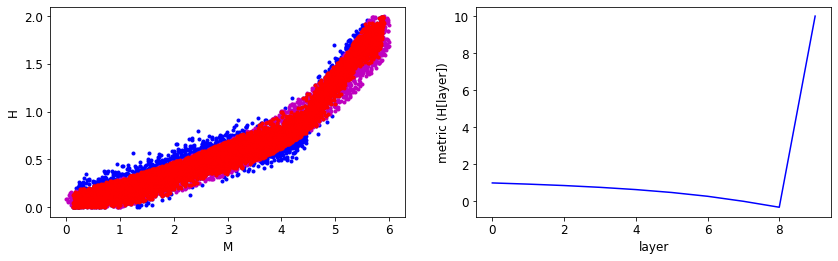

training epoch: 4200,   loss: 0.00948848482221365
m2: 0.0861533060669899, lambda: -0.22075574100017548, alpha: 0.19879655539989471, beta: 0.08887577056884766
[ 0.9763248   0.91201067  0.83538276  0.73851728  0.61657542  0.45987487
  0.25443062 -0.01649553 -0.33861315 10.        ]


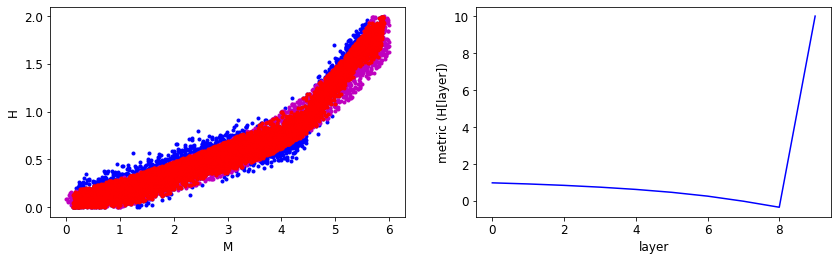

training epoch: 4300,   loss: 0.0094729233533144
m2: 0.08803704380989075, lambda: -0.21942239999771118, alpha: 0.19671793282032013, beta: 0.08876719325780869
[ 0.97426611  0.91423726  0.83763796  0.74062324  0.61839151  0.46140438
  0.2544305  -0.02041996 -0.34688798 10.        ]


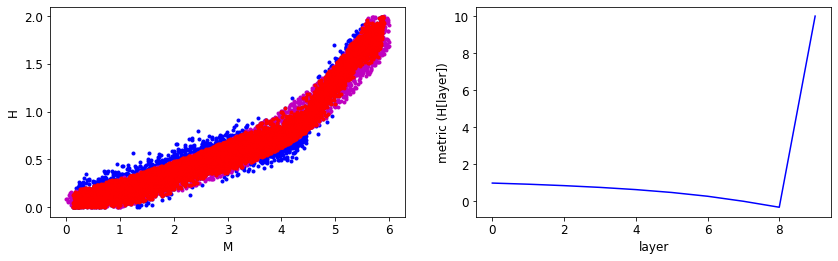

training epoch: 4400,   loss: 0.009545189328491688
m2: 0.08592497557401657, lambda: -0.22175109386444092, alpha: 0.19894711673259735, beta: 0.08813109248876572
[ 9.74848032e-01  9.13451135e-01  8.36084306e-01  7.41530120e-01
  6.21617019e-01  4.66703385e-01  2.62374818e-01 -8.78047477e-03
 -3.31954271e-01  1.00000000e+01]


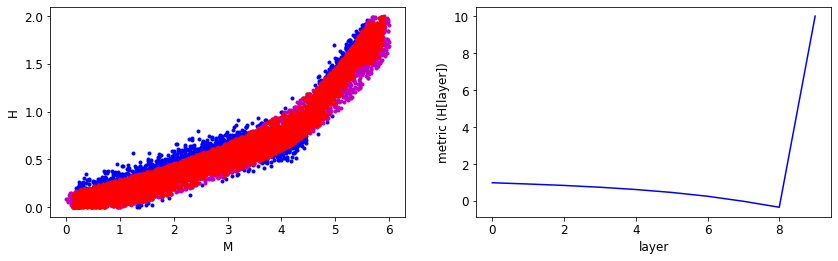

training epoch: 4500,   loss: 0.009683012962341309
m2: 0.08464029431343079, lambda: -0.22563479840755463, alpha: 0.19935853779315948, beta: 0.09125666320323944
[ 0.97866386  0.91040397  0.83294487  0.73554128  0.61242735  0.45459968
  0.24795686 -0.02445048 -0.347579   10.        ]


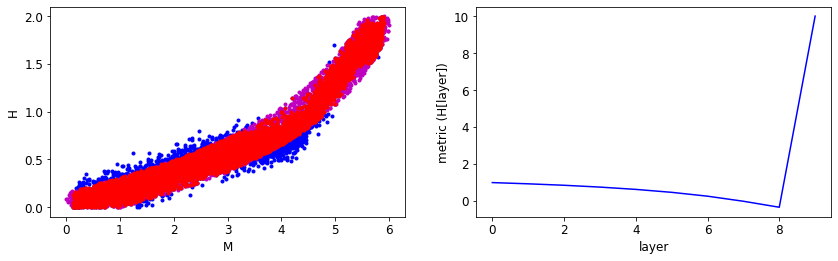

training epoch: 4600,   loss: 0.009671752341091633
m2: 0.08923384547233582, lambda: -0.2257525622844696, alpha: 0.20024114847183228, beta: 0.08785992860794067
[ 0.9745934   0.90754062  0.82885683  0.72989774  0.60540527  0.44584265
  0.23695536 -0.03768432 -0.36241424 10.        ]


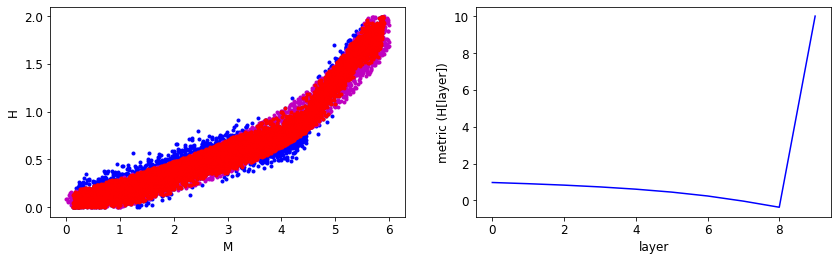

training epoch: 4700,   loss: 0.009720094501972198
m2: 0.08841713517904282, lambda: -0.22234001755714417, alpha: 0.19841651618480682, beta: 0.08887273818254471
[ 0.97509742  0.90953881  0.83243877  0.73587155  0.61293936  0.45384365
  0.24359928 -0.03561522 -0.36730048 10.        ]


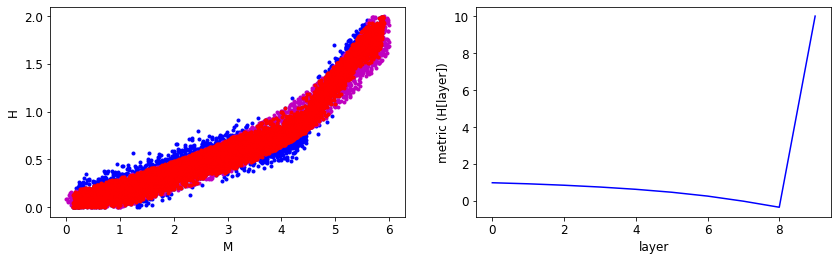

training epoch: 4800,   loss: 0.009505684487521648
m2: 0.09032447636127472, lambda: -0.21951359510421753, alpha: 0.19671201705932617, beta: 0.08849827945232391
[ 0.9723832   0.9146598   0.83761245  0.74038154  0.6168341   0.45791313
  0.24912162 -0.02679561 -0.35499436 10.        ]


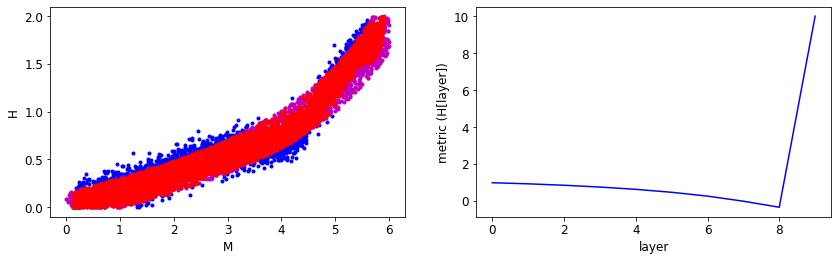

training epoch: 4900,   loss: 0.00941155944019556
m2: 0.08941841870546341, lambda: -0.21764269471168518, alpha: 0.19673588871955872, beta: 0.0880126953125
[ 0.97430861  0.91534066  0.83821422  0.74070466  0.61669815  0.45727357
  0.24882977 -0.02589349 -0.3529582  10.        ]


In [10]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_phase_and_metric(threshold=0.1, eta_or_layer='layer',
                                         positive_H_M_F=Positive_HM, negative_H_M_F=Negative_HM, Net=Test)
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("m2: {}, lambda: {}, alpha: {}, beta: {}".format(Test.show_m2().data.numpy()[0], Test.show_lamb().data.numpy()[0], Test.show_alpha().data.numpy()[0], Test.show_beta().data.numpy()[0]))
        print(np.array([v[0] for v in Hs]))